In [2]:
import pandas as pd
import numpy as np 

In [3]:
data_path = '../data'

In [4]:
fed_rates = pd.read_csv(data_path + '/FED Data/Fed Rates/DFEDTARU.csv')

In [5]:
meeting_date = '20230322'

In [6]:
# Function to check if 500 is in the range
def is_500_in_range(range_str,final_rate):
    # Splitting the string to get the numerical range
    start, end = map(int, range_str[1:-1].split('-'))
    return final_rate >= start and final_rate <= end

def processing(data_path,fed_rates,meeting_date):

    march_2023 = pd.read_csv(data_path + f'/CME Data/Data from CME (Excels)/Excels/FedMeeting_{meeting_date}.csv')
    non_zero_columns = march_2023.columns[1:][(march_2023.iloc[:, 1:].sum(axis=0) != 0).values].tolist()
    # Filter the dataframe to include only columns with non-zero values
    non_zero_df = march_2023[['Date'] + non_zero_columns]

    # Display the first few rows of the new dataframe
    non_zero_df['Date'] = pd.to_datetime(non_zero_df['Date'])
    non_zero_df.fillna(0, inplace=True)
    # Find the column name of the maximum number per date
    max_columns_per_date = non_zero_df.set_index('Date').idxmax(axis=1)
    max_columns_per_date = pd.DataFrame(max_columns_per_date)
    max_columns_per_date.columns = ['most_chosen']

    next_date = str(pd.to_datetime(meeting_date)+pd.Timedelta(days=1)).split(' ')[0]
    final_rate = fed_rates[fed_rates['DATE']==next_date]['DFEDTARU'].values[0]
    final_rate*=100

    # Applying the function to create a new column
    max_columns_per_date['is_correct'] = max_columns_per_date['most_chosen'].apply(lambda x: is_500_in_range(x,final_rate))
    max_columns_per_date['is_correct'] = max_columns_per_date['is_correct'].astype(int)

    max_columns_per_date = max_columns_per_date.reset_index()
    max_columns_per_date['days_until_meeting'] = pd.to_datetime(next_date) - max_columns_per_date['Date']
    max_columns_per_date['days_until_meeting'] = max_columns_per_date['days_until_meeting'].apply(lambda x: x.days)

    # add aditional columns fix later 
    max_columns_per_date['std_gambling'] = np.nan
    max_columns_per_date['kurtosis'] = np.nan
    max_columns_per_date['number_of_rate_decisions_in_between'] = np.nan
    max_columns_per_date['number_of_expected_rate_events_in_between'] = np.nan

    return max_columns_per_date


In [7]:
meeting_dates = ['20230322','20230503','20230614','20230920','20230726']
df_full = pd.DataFrame()

for meeting_date in meeting_dates: 
    df = processing(data_path,fed_rates,meeting_date)
    df_full = pd.concat([df_full,df],axis=0)

/var/folders/13/ppcv25kx417d7qkyfjzc0j200000gn/T/ipykernel_23027/132782627.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero_df['Date'] = pd.to_datetime(non_zero_df['Date'])
/var/folders/13/ppcv25kx417d7qkyfjzc0j200000gn/T/ipykernel_23027/132782627.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero_df.fillna(0, inplace=True)
/var/folders/13/ppcv25kx417d7qkyfjzc0j200000gn/T/ipykernel_23027/132782627.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [8]:
df_full.head()

,Date,most_chosen,is_correct,days_until_meeting,std_gambling,kurtosis,number_of_rate_decisions_in_between,number_of_expected_rate_events_in_between
0,2022-08-17,(350-375),0,218,NaN,NaN,NaN,NaN
1,2022-08-18,(350-375),0,217,NaN,NaN,NaN,NaN
2,2022-08-19,(350-375),0,216,NaN,NaN,NaN,NaN
3,2022-08-22,(375-400),0,213,NaN,NaN,NaN,NaN
4,2022-08-23,(375-400),0,212,NaN,NaN,NaN,NaN


In [9]:
df_full.tail()

,Date,most_chosen,is_correct,days_until_meeting,std_gambling,kurtosis,number_of_rate_decisions_in_between,number_of_expected_rate_events_in_between
231,2023-07-20,(525-550),1,7,NaN,NaN,NaN,NaN
232,2023-07-21,(525-550),1,6,NaN,NaN,NaN,NaN
233,2023-07-24,(525-550),1,3,NaN,NaN,NaN,NaN
234,2023-07-25,(525-550),1,2,NaN,NaN,NaN,NaN
235,2023-07-26,(525-550),1,1,NaN,NaN,NaN,NaN


In [10]:
df_full['Date'].value_counts()

Date
2023-02-16    5
2022-12-30    5
2023-01-04    5
2023-01-05    5
2023-01-06    5
             ..
2023-08-01    1
2023-07-31    1
2023-07-28    1
2023-07-27    1
2023-08-17    1
Name: count, Length: 253, dtype: int64

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [12]:
df['days_until_meeting'].value_counts()

days_until_meeting
343    1
107    1
125    1
122    1
121    1
      ..
225    1
224    1
223    1
220    1
1      1
Name: count, Length: 236, dtype: int64

In [13]:
df = df_full 

# Preprocessing the data
# Dropping 'Date' and 'most_chosen' columns
df = df.drop(['Date', 'most_chosen'], axis=1)

# Fill NaN values with 0 (or another strategy can be chosen)
df.fillna(0, inplace=True)

# Splitting the data into features and target
X = df.drop('is_correct', axis=1)
y = df['is_correct']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating and training the RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = random_forest_model.predict(X_test)
y_proba = random_forest_model.predict_proba(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


In [14]:
accuracy

0.7077922077922078

In [15]:
X_test.head()

,days_until_meeting,std_gambling,kurtosis,number_of_rate_decisions_in_between,number_of_expected_rate_events_in_between
198,14,0.0,0.0,0.0,0.0
30,258,0.0,0.0,0.0,0.0
118,128,0.0,0.0,0.0,0.0
31,174,0.0,0.0,0.0,0.0
84,279,0.0,0.0,0.0,0.0


In [16]:
y_proba[:, 1]

array([1.        , 0.        , 0.0277619 , 0.        , 0.        ,
       0.        , 0.        , 0.498     , 0.498     , 0.49403968,
       0.57965476, 0.67102778, 0.05214286, 0.30990476, 0.        ,
       0.04702381, 1.        , 0.        , 0.        , 0.30621429,
       0.9075    , 0.        , 0.        , 0.66133333, 0.0065    ,
       0.        , 0.98857143, 0.98857143, 0.42522763, 0.30052381,
       0.        , 0.86942857, 1.        , 0.        , 0.67413492,
       0.30990476, 0.51266667, 0.        , 0.74071429, 0.86942857,
       0.        , 0.        , 0.        , 0.52285714, 0.        ,
       0.        , 1.        , 0.        , 0.72968975, 0.95888095,
       0.0065    , 1.        , 0.        , 0.        , 1.        ,
       0.30052381, 0.        , 0.        , 0.32542857, 0.        ,
       0.        , 0.02416667, 0.039     , 0.38      , 0.94866667,
       0.        , 0.        , 0.        , 0.3172381 , 0.31138095,
       1.        , 0.72347619, 0.        , 0.31722222, 0.     

In [17]:
y_proba

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [0.9722381 , 0.0277619 ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.502     , 0.498     ],
       [0.502     , 0.498     ],
       [0.50596032, 0.49403968],
       [0.42034524, 0.57965476],
       [0.32897222, 0.67102778],
       [0.94785714, 0.05214286],
       [0.69009524, 0.30990476],
       [1.        , 0.        ],
       [0.95297619, 0.04702381],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.69378571, 0.30621429],
       [0.0925    , 0.9075    ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.33866667, 0.66133333],
       [0.9935    , 0.0065    ],
       [1.        , 0.        ],
       [0.01142857, 0.98857143],
       [0.01142857, 0.98857143],
       [0.57477237, 0.42522763],
       [0.69947619, 0.30052381],
       [1.

In [32]:
test_full = pd.DataFrame()
i = 0 
while i < 101:
    test = pd.DataFrame([i,0,0,0,0]).T
    test.columns = X_test.columns
    test_full = pd.concat([test_full,test],axis=0)
    i+=1

In [33]:
test_output = random_forest_model.predict_proba(test_full)

In [34]:
test_output[:, 1]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.63859524,
       0.86942857, 0.97988095, 1.        , 0.996     , 0.94866667,
       0.67413492, 0.77972475, 0.77053571, 0.79269444, 0.79269444,
       0.80706277, 0.80706277, 0.99277778, 1.        , 1.        ,
       1.        , 1.        , 0.77844841, 0.77844841, 0.98958333,
       0.74828968, 0.95888095, 0.74071429, 0.74071429, 0.9925    ,
       0.98857143, 0.72968975, 0.98      , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.81156241, 0.51266667, 0.51266667, 0.71370238, 0.72075   ,
       0.60071825, 0.30990476, 0.11516667, 0.58383333, 0.59933

In [35]:

test_full['prediction'] = test_output[:, 1]

In [36]:
test_full

,days_until_meeting,std_gambling,kurtosis,number_of_rate_decisions_in_between,number_of_expected_rate_events_in_between,prediction
0,0,0,0,0,0,1.000000
0,1,0,0,0,0,1.000000
0,2,0,0,0,0,1.000000
0,3,0,0,0,0,1.000000
0,4,0,0,0,0,1.000000
...,...,...,...,...,...,...
0,96,0,0,0,0,0.950000
0,97,0,0,0,0,0.960000
0,98,0,0,0,0,0.380000
0,99,0,0,0,0,0.654238


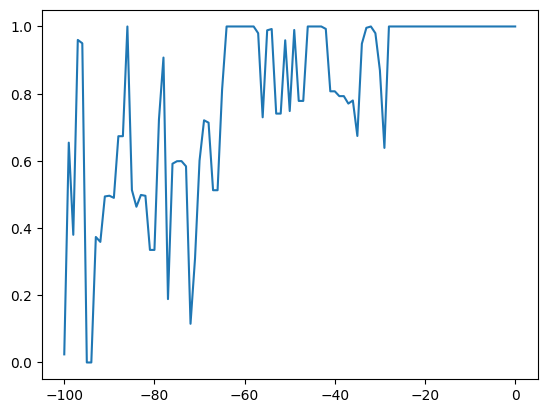

In [37]:
import matplotlib.pyplot as plt  
plt.plot(test_full['days_until_meeting']*-1,test_full['prediction'])

In [38]:
# we use this randomforest in combination with the potential profit to decide when to gamble on the gamblers 

In [39]:
# lets say we find -40 days is 100% change that the basket with most gamblers in it is correct 
# and -40 days has a high reward we want to choose that. 
# you can run this simulation to find that threshold when to start gambling. Because you can also use it to construct predictions based on what we know now

In [40]:

test_full['incentive'] = test_full['days_until_meeting']/60
test_full.loc[test_full['days_until_meeting']>60,'incentive']=0
test_full['potential_profit'] = test_full['prediction'] * test_full['incentive']
test_full



,days_until_meeting,std_gambling,kurtosis,number_of_rate_decisions_in_between,number_of_expected_rate_events_in_between,prediction,incentive,potential_profit
0,0,0,0,0,0,1.000000,0.000000,0.000000
0,1,0,0,0,0,1.000000,0.016667,0.016667
0,2,0,0,0,0,1.000000,0.033333,0.033333
0,3,0,0,0,0,1.000000,0.050000,0.050000
0,4,0,0,0,0,1.000000,0.066667,0.066667
...,...,...,...,...,...,...,...,...
0,96,0,0,0,0,0.950000,0.000000,0.000000
0,97,0,0,0,0,0.960000,0.000000,0.000000
0,98,0,0,0,0,0.380000,0.000000,0.000000
0,99,0,0,0,0,0.654238,0.000000,0.000000


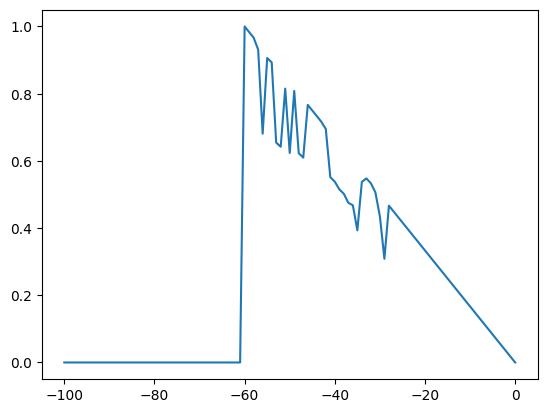

In [41]:
plt.plot(test_full['days_until_meeting']*-1,test_full['potential_profit'])

In [45]:
window_size = 14  # Define the window size for the rolling average
test_full['prediction_rolling_avg'] = test_full['prediction'].rolling(window=window_size).mean()
test_full

,days_until_meeting,std_gambling,kurtosis,number_of_rate_decisions_in_between,number_of_expected_rate_events_in_between,prediction,incentive,potential_profit,prediction_rolling_avg,potential_profit_prediction_rolling_avg
0,0,0,0,0,0,1.000000,0.000000,0.000000,NaN,0.000000
0,1,0,0,0,0,1.000000,0.016667,0.016667,NaN,0.016667
0,2,0,0,0,0,1.000000,0.033333,0.033333,NaN,0.033333
0,3,0,0,0,0,1.000000,0.050000,0.050000,NaN,0.050000
0,4,0,0,0,0,1.000000,0.066667,0.066667,NaN,0.066667
...,...,...,...,...,...,...,...,...,...,...
0,96,0,0,0,0,0.950000,0.000000,0.000000,0.498929,0.000000
0,97,0,0,0,0,0.960000,0.000000,0.000000,0.531887,0.000000
0,98,0,0,0,0,0.380000,0.000000,0.000000,0.525921,0.000000
0,99,0,0,0,0,0.654238,0.000000,0.000000,0.535988,0.000000


In [46]:
test_full['prediction_rolling_avg'] = test_full['prediction_rolling_avg'].fillna(1)
test_full['potential_profit_prediction_rolling_avg'] = test_full['prediction_rolling_avg'] * test_full['incentive']

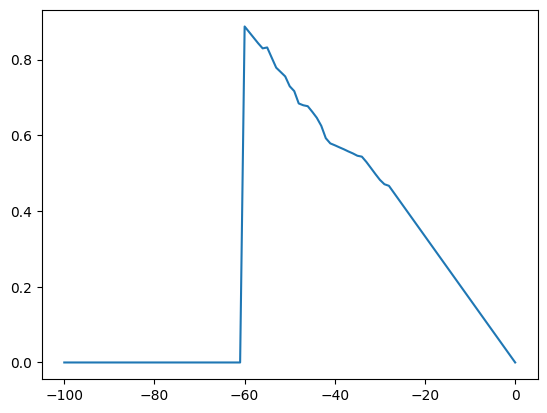

In [47]:
plt.plot(test_full['days_until_meeting']*-1,test_full['potential_profit_prediction_rolling_avg'])

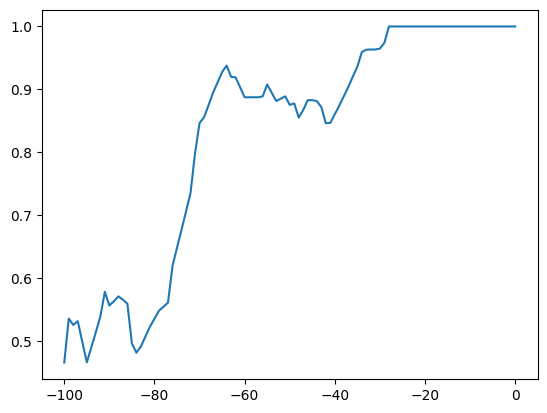

In [48]:
plt.plot(test_full['days_until_meeting']*-1,test_full['prediction_rolling_avg'])